# Anti-Spam - Preliminary data processing

In [ ]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import os
import re

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix


import scipy
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.linear_model import LogisticRegression
import math


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


## _SMS Spam Collection_

In [ ]:
df_sms = pd.read_csv("drive/MyDrive/NLP_datasets/SMSspamcollection/SMSSpamCollection",sep='\t',names=['cat','txt'])
df_sms.head()

,cat,txt
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


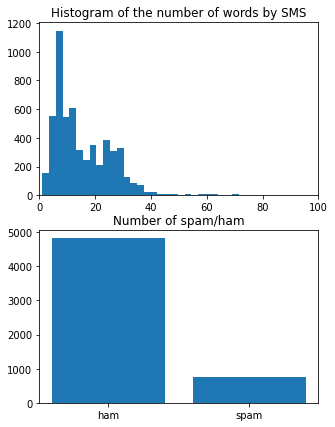

In [ ]:
number_of_words = df_sms['txt'].apply(lambda n: len(n.split()))

plt.figure(figsize=[5,7])
plt.subplot(2,1,1)
plt.hist(number_of_words, 70)
plt.xlim([0,100])
plt.title("Histogram of the number of words by SMS")
plt.subplot(2,1,2)
plt.bar(['ham','spam'], df_sms['cat'].value_counts()[['ham','spam']])
plt.title("Number of spam/ham")
plt.show()

## Enron

In [ ]:
df_enr = pd.DataFrame(columns=['cat', 'sub', 'txt'])
#df = df.append({'cat':'test_cat', 'sub':'test_sub', 'txt':'test_txt'}, ignore_index=True)

# Insert ham mails
dir_enron_ham = 'drive/MyDrive/NLP_datasets/enron/ham'
for filename in os.listdir(dir_enron_ham):
  with open(os.path.join(dir_enron_ham, filename), 'r', encoding="utf8", errors='ignore') as f:
    list_text = f.readlines()
    sub = list_text[0][9:].rstrip() # Parse the subject line
    txt = ' '.join(list_text[1:])
    df_enr = df_enr.append({'cat':'ham', 'sub':sub, 'txt':txt}, ignore_index=True)
    f.close()

# Insert spam mails
dir_enron_spam = 'drive/MyDrive/NLP_datasets/enron/spam'
for filename in os.listdir(dir_enron_spam):
  with open(os.path.join(dir_enron_spam, filename), 'r', encoding="utf8", errors='ignore') as f:
    try:
      list_text = f.readlines()
    except:
      print(filename)
    sub = list_text[0][9:].rstrip() # Parse the subject line
    txt = ' '.join(list_text[1:])
    df_enr = df_enr.append({'cat':'spam', 'sub':sub, 'txt':txt}, ignore_index=True)
    f.close()

df_enr.head()

,cat,sub,txt
0,ham,updated q & as for enron employees,updated questions and answers for enron employ...
1,ham,http : / / hrweb . enron . com / benefits / fo...,
2,ham,united way 2001 - building houston ' s future,"building houston ' s future , enron ' s 2001 u..."
3,ham,fw : tw rofr,"fyi , kim .\n - - - - - original message - - -..."
4,ham,br / tw window rock meeting scheduled for dec ...,"michelle ,\n we are looking forward to the pla..."


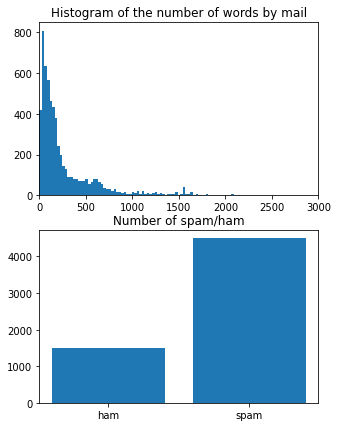

In [ ]:
number_of_words = df_enr['txt'].apply(lambda n: len(n.split()))

plt.figure(figsize=[5,7])
plt.subplot(2,1,1)
plt.hist(number_of_words, 200)
plt.xlim([0,3000])
plt.title("Histogram of the number of words by mail")
plt.subplot(2,1,2)
plt.bar(['ham','spam'], df_enr['cat'].value_counts()[['ham','spam']])
plt.title("Number of spam/ham")
plt.show()

## Spam Assassin

In [ ]:
df_ass = pd.DataFrame(columns=['cat', 'sub', 'txt'])
re_sub = re.compile('[Ss]ubject ?:')

# Insert ham mails

dirs_ham = ['easy_ham', 'easy_ham_2']
for dir_ext in dirs_ham:
  dir_spamassassin_ham = 'drive/MyDrive/NLP_datasets/spamassassin/'+dir_ext
  for filename in os.listdir(dir_spamassassin_ham):
    with open(os.path.join(dir_spamassassin_ham, filename), 'r', encoding="utf8", errors='ignore') as f:
      sub = ""
      txt = ""
      header = True
      for line in f:
        line = line.rstrip()
        if header:
          if line == "":
            header = False
          elif re_sub.match(line):
            sub = line[re_sub.match(line).span()[1]:] # Parse the subject line
        else:
          txt = txt + " " + line 
      txt = txt[1:]
      df_ass = df_ass.append({'cat':'ham', 'sub':sub, 'txt':txt}, ignore_index=True)
      f.close()

In [ ]:
# Insert spam mails
dirs_spam = ['spam', 'spam_2']
for dir_ext in dirs_spam:
  dir_spamassassin_spam = 'drive/MyDrive/NLP_datasets/spamassassin/'+dir_ext
  for filename in os.listdir(dir_spamassassin_spam):
    with open(os.path.join(dir_spamassassin_spam, filename), 'r', encoding="utf8", errors='ignore') as f:
      ub = ""
      txt = ""
      header = True
      for line in f:
        line = line.rstrip()
        if header:
          if line == "":
            header = False
          elif re_sub.match(line):
            sub = line[re_sub.match(line).span()[1]:] # Parse the subject line
        else:
          txt = txt + " " + line 
      txt = txt[1:]
      df_ass = df_ass.append({'cat':'spam', 'sub':sub, 'txt':txt}, ignore_index=True)
      f.close()

df_ass.head()

,cat,sub,txt
0,ham,[SAdev] [Bug 1008] SpamAssassin does not work...,http://www.hughes-family.org/bugzilla/show_bug...
1,ham,[SAdev] [Bug 839] mailbox corruption not fixe...,http://www.hughes-family.org/bugzilla/show_bug...
2,ham,[Spambayes] test sets?,">>>>> ""GvR"" == Guido van Rossum <guido@python..."
3,ham,Re: [Razor-users] Razor with sendmail,"""Bort, Paul"" <pbort@tmwsystems.com> wrote: >If..."
4,ham,Jeremy Zawodny who works at Yahoo Finance off...,URL: http://scriptingnews.userland.com/backiss...


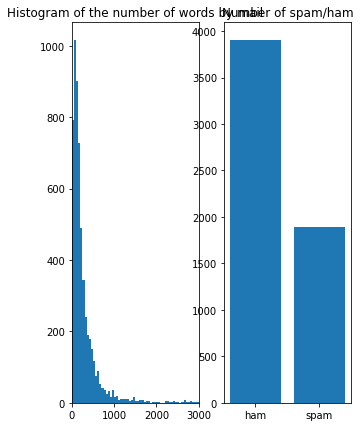

In [ ]:
number_of_words = df_ass['txt'].apply(lambda n: len(n.split()))

plt.figure(figsize=[5,7])
plt.subplot(1,2,1)
plt.hist(number_of_words, 300)
plt.xlim([0,3000])
plt.title("Histogram of the number of words by mail")
plt.subplot(1,2,2)
plt.bar(['ham','spam'], df_ass['cat'].value_counts()[['ham','spam']])
plt.title("Number of spam/ham")
plt.show()

## Preprocessing

In [ ]:
def preprocessing(df, bool_sub):
  # Lowercase
  txt_tkn = df['txt'].str.lower()
  if bool_sub: 
    sub_tkn = df['sub'].str.lower()

  # Tokenize
  new_stopwords = ['enron', 'com', 'http', 'nbsp']
  stop_words = set(stopwords.words('english') + new_stopwords)

  stemmer = PorterStemmer()
  lemmatizer = WordNetLemmatizer()

  tokenized_txt = []
  for str in txt_tkn:
    
    str = re.sub(r'<.+?>', '', str)
    str = re.sub(r'\S*https?:\S*', '', str)
    str = re.sub(r'\d+', '', str)
    str = re.sub(r'[^\w\s]', ' ', str)
    str = re.sub('email', 'mail', str)


    words = word_tokenize(str)
    # Remove stopwords
    words = [w for w in words if (not w in stop_words and len(w)>2)]
    # Stemmatization
    #words = [stemmer.stem(w) for w in words]
    # Lemmatization
    words = [lemmatizer.lemmatize(w,pos=wordnet.NOUN) for w in words]
    words = [lemmatizer.lemmatize(w,pos=wordnet.VERB) for w in words]
    words = [lemmatizer.lemmatize(w,pos=wordnet.ADJ) for w in words]
    #filtered_sentence = []
      
    #for w in word_tokens:
    #    if w not in stop_words:
    #        filtered_sentence.append(w)
    
    tokenized_txt.append(words)

  df['txt_tkn'] = tokenized_txt

  # sub
  tokenized_sub = []
  for str in sub_tkn:
    
    str = re.sub(r'<.+?>', '', str)
    str = re.sub(r'\S*https?:\S*', '', str)
    str = re.sub(r'\d+', '', str)
    str = re.sub(r'[^\w\s]', ' ', str)
    str = re.sub('email', 'mail', str)


    words = word_tokenize(str)
    # Remove stopwords
    words = [w for w in words if (not w in stop_words and len(w)>2)]
    # Stemmatization
    #words = [stemmer.stem(w) for w in words]
    # Lemmatization
    words = [lemmatizer.lemmatize(w,pos=wordnet.NOUN) for w in words]
    words = [lemmatizer.lemmatize(w,pos=wordnet.VERB) for w in words]
    words = [lemmatizer.lemmatize(w,pos=wordnet.ADJ) for w in words]
    #filtered_sentence = []
      
    #for w in word_tokens:
    #    if w not in stop_words:
    #        filtered_sentence.append(w)
    
    tokenized_sub.append(words)

  df['sub_tkn'] = tokenized_sub

In [ ]:

preprocessing(df_ass, True)
df_ass

,cat,sub,txt,txt_tkn,sub_tkn
0,ham,[SAdev] [Bug 1008] SpamAssassin does not work...,http://www.hughes-family.org/bugzilla/show_bug...,"[jmason, org, change, remove, add, status, new...","[sadev, bug, spamassassin, work, glance]"
1,ham,[SAdev] [Bug 839] mailbox corruption not fixe...,http://www.hughes-family.org/bugzilla/show_bug...,"[additional, comment, alan, rdrop, try, yet, r...","[sadev, bug, mailbox, corruption, fix, procmail]"
2,ham,[Spambayes] test sets?,">>>>> ""GvR"" == Guido van Rossum <guido@python...","[gvr, guido, van, rossum, write, gvr, perhaps,...","[spambayes, test, set]"
3,ham,Re: [Razor-users] Razor with sendmail,"""Bort, Paul"" <pbort@tmwsystems.com> wrote: >If...","[bort, paul, write, sendmail, compile, milter,...","[razor, user, razor, sendmail]"
4,ham,Jeremy Zawodny who works at Yahoo Finance off...,URL: http://scriptingnews.userland.com/backiss...,"[url, date, mon, sep, gmt, jeremy, zawodny, wo...","[jeremy, zawodny, work, yahoo, finance, offer,..."
...,...,...,...,...,...
5791,spam,Turn Your PayPal account into a Non-Stop Cash...,I am sending you this message because we have ...,"[send, message, communicate, past, business, o...","[turn, paypal, account, non, stop, cash, machi..."
5792,spam,Stop creditors in their tracks 10891,** 5 FREE eBooks JUST FOR SIGNING UP. Sent via...,"[free, ebooks, sign, send, via, mail, within, ...","[stop, creditor, track]"
5793,spam,Online Approval for $5000 Now,<HTML><HEAD><TITLE>Free Card Search</TITLE> <M...,"[free, card, search, sincerely, new, offer, st...","[online, approval]"
5794,spam,hello,FROM=SEKO MOSHOOD MOBUTU Tel=234-1-776-2397 ...,"[seko, moshood, mobutu, tel, dear, friend, fir...",[hello]


In [ ]:
preprocessing(df_enr, True)
df_enr

,cat,sub,txt,txt_tkn,sub_tkn
0,ham,updated q & as for enron employees,updated questions and answers for enron employ...,"[update, question, answer, employee, post, hom...","[update, employee]"
1,ham,http : / / hrweb . enron . com / benefits / fo...,,[],"[hrweb, benefit, formp, asp]"
2,ham,united way 2001 - building houston ' s future,"building houston ' s future , enron ' s 2001 u...","[build, houston, future, unite, way, campaign,...","[unite, way, build, houston, future]"
3,ham,fw : tw rofr,"fyi , kim .\n - - - - - original message - - -...","[fyi, kim, original, message, harris, steven, ...",[rofr]
4,ham,br / tw window rock meeting scheduled for dec ...,"michelle ,\n we are looking forward to the pla...","[michelle, look, forward, plan, meet, discus, ...","[window, rock, meet, schedule, dec]"
...,...,...,...,...,...
6005,spam,miss you,"heytherecutie ,\n haven ' tseen youaround thes...","[heytherecutie, tseen, youaround, thesiteinawh...",[miss]
6006,spam,we understand your credit status,"hello ,\n you have been chosen to participate ...","[hello, choose, participate, invitation, event...","[understand, credit, status]"
6007,spam,free adult personals,biggest adult datlng dat 4 base with web c 4 m...,"[big, adult, datlng, dat, base, web, mscllck, ...","[free, adult, personal]"
6008,spam,ciallis softabs onlly $ 3 . 99 wkrk,""" ci - ialis softabs "" is better than pfizer v...","[ialis, softabs, good, pfizer, viiagrra, norma...","[ciallis, softabs, onlly, wkrk]"


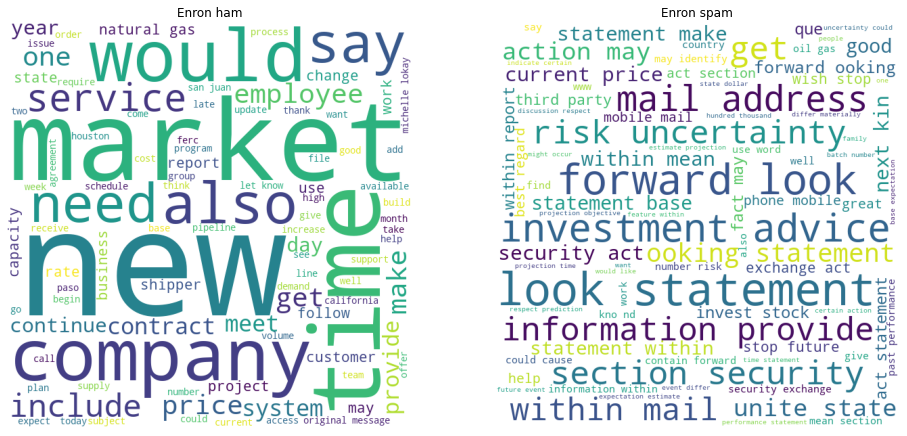

In [ ]:
input_txt_ham = " ".join([" ".join(list_of_words) for list_of_words in df_enr['txt_tkn'][df_enr['cat']=='ham']])
input_txt_spam = " ".join([" ".join(list_of_words) for list_of_words in df_enr['txt_tkn'][df_enr['cat']=='spam']])
#input_txt = " ".join(df_ass['txt'])

wordcloud_ham = WordCloud(width = 600, height = 600,
                background_color ='white',
                stopwords = stopwords.words('english'),
                min_font_size = 10).generate(input_txt_ham)

wordcloud_spam = WordCloud(width = 600, height = 600,
                background_color ='white',
                stopwords = stopwords.words('english'),
                min_font_size = 10).generate(input_txt_spam)
 
# plot the WordCloud image                      
plt.figure(figsize = (16, 8))

plt.subplot(1,2,1)
plt.imshow(wordcloud_ham)
plt.axis("off")
#plt.tight_layout(pad = 0)
plt.title('Enron ham')

plt.subplot(1,2,2)
plt.imshow(wordcloud_spam)
plt.axis("off")
#plt.tight_layout(pad = 0)
plt.title('Enron spam')
 
plt.show()

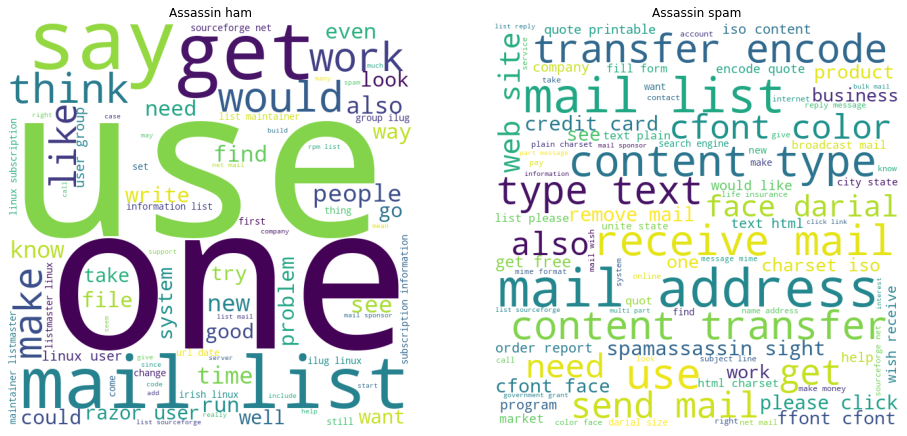

In [ ]:
input_txt_ham = " ".join([" ".join(list_of_words) for list_of_words in df_ass['txt_tkn'][df_ass['cat']=='ham']])
input_txt_spam = " ".join([" ".join(list_of_words) for list_of_words in df_ass['txt_tkn'][df_ass['cat']=='spam']])
#input_txt = " ".join(df_ass['txt'])

wordcloud_ham = WordCloud(width = 600, height = 600,
                background_color ='white',
                stopwords = stopwords.words('english'),
                min_font_size = 10).generate(input_txt_ham)

wordcloud_spam = WordCloud(width = 600, height = 600,
                background_color ='white',
                stopwords = stopwords.words('english'),
                min_font_size = 10).generate(input_txt_spam)
 
# plot the WordCloud image                      
plt.figure(figsize = (16, 8))

plt.subplot(1,2,1)
plt.imshow(wordcloud_ham)
plt.axis("off")
#plt.tight_layout(pad = 0)
plt.title('Assassin ham')

plt.subplot(1,2,2)
plt.imshow(wordcloud_spam)
plt.axis("off")
#plt.tight_layout(pad = 0)
plt.title('Assassin spam')
 
plt.show()

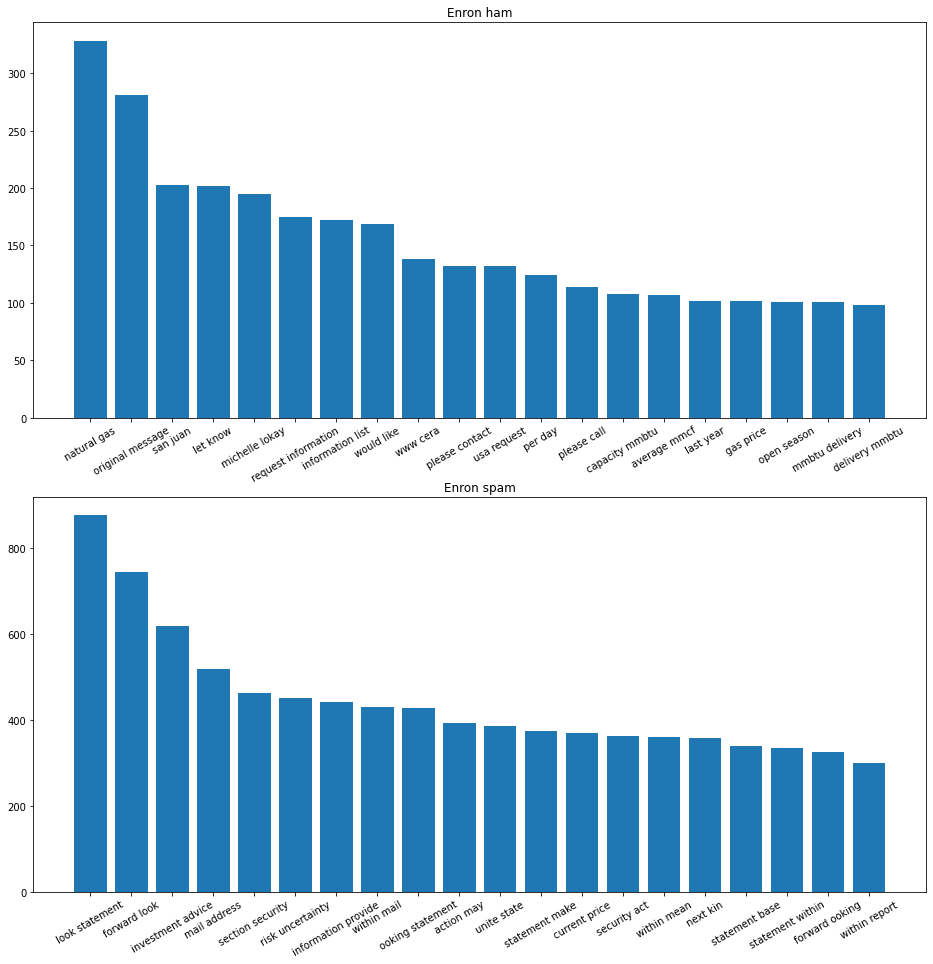

In [ ]:
words_ham_ = df_enr['txt_tkn'][df_enr['cat']=='ham']
words_spam_ = df_enr['txt_tkn'][df_enr['cat']=='spam']

words_ham = [wrd for line in words_ham_.tolist() for wrd in line]
words_spam = [wrd for line in words_spam_.tolist() for wrd in line]

bigrams_ham = nltk.bigrams(words_ham)
freq_ham = nltk.FreqDist(bigrams_ham).most_common(20)
freq_ham = pd.Series(dict(freq_ham))

bigrams_spam = nltk.bigrams(words_spam)
freq_spam = nltk.FreqDist(bigrams_spam).most_common(20)
freq_spam = pd.Series(dict(freq_spam))

plt.figure(figsize = (16, 16))

plt.subplot(2,1,1)

y = freq_ham.values
x = [ b[0]+' '+b[1] for b in freq_ham.index]

plt.bar(x,y)
plt.xticks(rotation=30);
plt.title('Enron ham')

plt.subplot(2,1,2)

y = freq_spam.values
x = [ b[0]+' '+b[1] for b in freq_spam.index]

plt.bar(x,y)
plt.xticks(rotation=30);
plt.title('Enron spam')
 
plt.show()

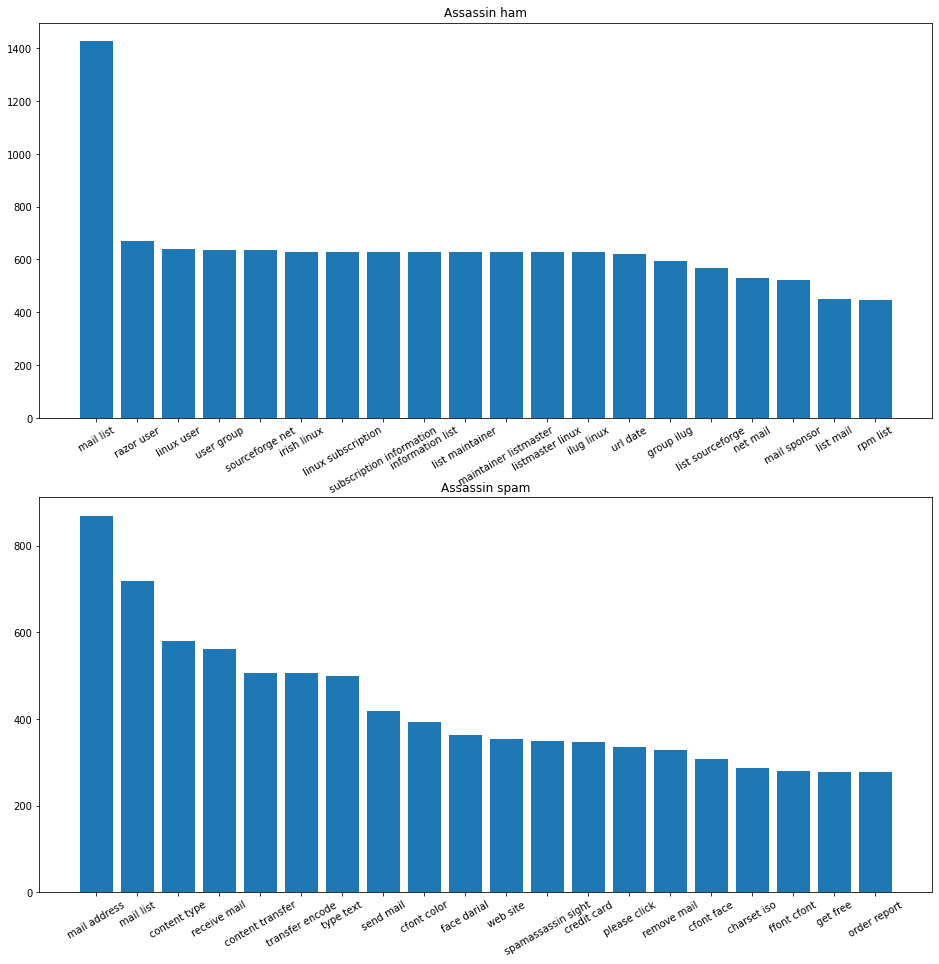

In [ ]:
words_ham_ = df_ass['txt_tkn'][df_ass['cat']=='ham']
words_spam_ = df_ass['txt_tkn'][df_ass['cat']=='spam']

words_ham = [wrd for line in words_ham_.tolist() for wrd in line]
words_spam = [wrd for line in words_spam_.tolist() for wrd in line]

bigrams_ham = nltk.bigrams(words_ham)
freq_ham = nltk.FreqDist(bigrams_ham).most_common(20)
freq_ham = pd.Series(dict(freq_ham))

bigrams_spam = nltk.bigrams(words_spam)
freq_spam = nltk.FreqDist(bigrams_spam).most_common(20)
freq_spam = pd.Series(dict(freq_spam))

plt.figure(figsize = (16, 16))

plt.subplot(2,1,1)

y = freq_ham.values
x = [ b[0]+' '+b[1] for b in freq_ham.index]

plt.bar(x,y)
plt.xticks(rotation=30);
plt.title('Assassin ham')

plt.subplot(2,1,2)

y = freq_spam.values
x = [ b[0]+' '+b[1] for b in freq_spam.index]

plt.bar(x,y)
plt.xticks(rotation=30);
plt.title('Assassin spam')
 
plt.show()

## Feature Extraction 

## Classification

In [ ]:
(x_train,x_test,y_train,y_test)=train_test_split(df_enr['txt_tkn'],df_enr['cat'],test_size=0.2)
#x_train.head()
indexes_of_x_train = x_train.index
indexes_of_x_test = x_test.index

In [ ]:
# create the transform
vectorizer = CountVectorizer()

# tokenize and build vocab
x_train_features = vectorizer.fit_transform(x_train.apply(lambda x: " ".join(x) ))
x_test_features = vectorizer.transform(x_test.apply(lambda x: " ".join(x) ))

In [ ]:
vectorizer.vocabulary_

{'jim': 24729,
 'prentice': 35716,
 'president': 35783,
 'clean': 8662,
 'fuel': 18594,
 'recently': 37699,
 'honor': 21727,
 'child': 8162,
 'advocate': 834,
 'inc': 22943,
 'hero': 21196,
 'sword': 43771,
 'award': 3758,
 'high': 21348,
 'bestow': 4904,
 'upon': 46996,
 'donor': 13678,
 'supporter': 43543,
 'volunteer': 48258,
 'leader': 26417,
 'present': 35763,
 'recognition': 37765,
 'outstanding': 33052,
 'leadership': 26419,
 'chairman': 7853,
 'houston': 21889,
 'festival': 17371,
 'past': 33701,
 'three': 44907,
 'year': 50105,
 'raise': 37313,
 'million': 29428,
 'support': 43542,
 'effort': 14679,
 'involve': 23988,
 'since': 41470,
 'truly': 45955,
 'deserve': 12487,
 'symbolic': 43813,
 'slay': 41693,
 'dragon': 13862,
 'abuse': 240,
 'make': 28008,
 'many': 28198,
 'whose': 49038,
 'life': 26827,
 'change': 7901,
 'good': 19777,
 'say': 40021,
 'tony': 45349,
 'terwilliger': 44540,
 'manager': 28093,
 'special': 42324,
 'event': 16340,
 'congratulation': 9815,
 'offfer': 

### Naive Bayes classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(x_train_features.toarray() ,y_train)

# Output of the score is the accuracy of the prediction
# Accuracy: 0.990
print("Training accuracy: ", clf.score(x_train_features.toarray(),y_train))
# Accuracy: 0.941
print("Testing accuracy: ", clf.score(x_test_features.toarray(),y_test))

Training accuracy:  0.9906405990016639
Testing accuracy:  0.9550748752079867


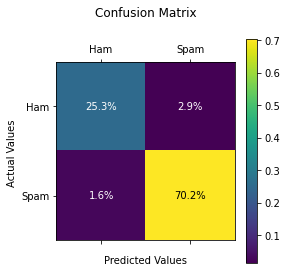

In [ ]:
y_pred = clf.predict(x_test_features.toarray())

conf_mat = confusion_matrix(y_test, y_pred) / len(y_test)

plt.matshow(conf_mat)

plt.title('Confusion Matrix\n\n')
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values ')

plt.colorbar()

plt.xticks([0,1],['Ham','Spam'])
plt.yticks([0,1], ['Ham','Spam'])

plt.text(0, 0, '{:0.1f}%'.format(conf_mat[0][0]*100), ha='center', va='center', c='w')
plt.text(0, 1, '{:0.1f}%'.format(conf_mat[0][1]*100), ha='center', va='center', c='w')
plt.text(1, 0, '{:0.1f}%'.format(conf_mat[1][0]*100), ha='center', va='center', c='w')
plt.text(1, 1, '{:0.1f}%'.format(conf_mat[1][1]*100), ha='center', va='center')

plt.show()


## DL classifier

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(df_enr['txt'], df_enr['cat'], test_size=0.2)
X_train =[' '.join(list_words) for list_words in x_train]
X_test =[' '.join(list_words) for list_words in x_test]

tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(X_train)

X_train_tok = tokenizer.texts_to_sequences(X_train)
X_train_tok = pad_sequences(X_train_tok, truncating = 'post', padding='post', maxlen=50)
X_test_tok = tokenizer.texts_to_sequences(X_test)
X_test_tok = pad_sequences(X_test_tok, truncating = 'post', padding='post', maxlen=50)

y_train_tok = [[1,0] if word == 'ham' else [0,1] for word in y_train]
y_train_tok = np.asarray(y_train_tok)

In [ ]:
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(10000,16,input_length=50),
tf.keras.layers.Dropout(.0),
tf.keras.layers.LSTM(20, return_sequences=True),
tf.keras.layers.Dropout(.0),
tf.keras.layers.LSTM(20),
tf.keras.layers.Dropout(.0),
tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(
     loss='categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 dropout (Dropout)           (None, 50, 16)            0         
                                                                 
 lstm (LSTM)                 (None, 50, 20)            2960      
                                                                 
 dropout_1 (Dropout)         (None, 50, 20)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [ ]:
model.fit(
     X_train_tok, y_train_tok,
     epochs=5, validation_split = 0.2)

Epoch 1/5
121/121 [==============================] - 14s 73ms/step - loss: 0.3561 - accuracy: 0.8534 - val_loss: 0.1337 - val_accuracy: 0.9699
Epoch 2/5
121/121 [==============================] - 9s 74ms/step - loss: 0.0806 - accuracy: 0.9797 - val_loss: 0.0942 - val_accuracy: 0.9678
Epoch 3/5
121/121 [==============================] - 11s 93ms/step - loss: 0.0365 - accuracy: 0.9922 - val_loss: 0.0744 - val_accuracy: 0.9740
Epoch 4/5
121/121 [==============================] - 8s 63ms/step - loss: 0.0186 - accuracy: 0.9953 - val_loss: 0.0736 - val_accuracy: 0.9751
Epoch 5/5
121/121 [==============================] - 7s 62ms/step - loss: 0.0120 - accuracy: 0.9977 - val_loss: 0.0758 - val_accuracy: 0.9782


In [ ]:
out = np.reshape(X_train_tok[0], (1,50))
print(model.predict(out))
last_lay_input = None
val = []
for lay in list(map(lambda x: x.name, model.layers)):
  if(last_lay_input is None ):
    last_lay_input = model.input
  intermediate_output = tf.keras.Model(last_lay_input, model.get_layer(lay).output)
  out = intermediate_output(out)
  #print(tf.reshape(out, [-1]))
  if(lay[0:7] != 'dropout' ):
    print(lay)
    val.append(tf.reshape(out, [-1]))
  last_lay_input = model.get_layer(lay).output
print(out)

1/1 [==============================] - 1s 918ms/step
[[0.9973742  0.00262579]]
embedding
lstm
lstm_1
dense
tf.Tensor([[0.9973742  0.00262579]], shape=(1, 2), dtype=float32)


38/38 [==============================] - 0s 10ms/step


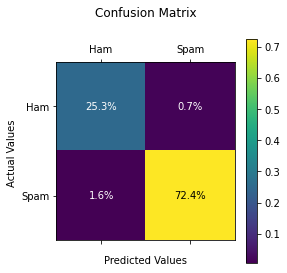

In [ ]:
y_pred = model.predict(X_test_tok)

y_pred_trim = [['ham','spam'][np.argmax(classes)] for classes in y_pred]

conf_mat = confusion_matrix(y_test, y_pred_trim) / len(y_test)

plt.matshow(conf_mat)

plt.title('Confusion Matrix\n\n')
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values ')

plt.colorbar()

plt.xticks([0,1],['Ham','Spam'])
plt.yticks([0,1], ['Ham','Spam'])

plt.text(0, 0, '{:0.1f}%'.format(conf_mat[0][0]*100), ha='center', va='center', c='w')
plt.text(0, 1, '{:0.1f}%'.format(conf_mat[0][1]*100), ha='center', va='center', c='w')
plt.text(1, 0, '{:0.1f}%'.format(conf_mat[1][0]*100), ha='center', va='center', c='w')
plt.text(1, 1, '{:0.1f}%'.format(conf_mat[1][1]*100), ha='center', va='center')

plt.show()


In [ ]:
w_indexs = []
for v in val:
  w_indexs.append(len(v))
w_indexs = w_indexs[0:-1]
print(w_indexs)

[800, 1000, 20]


In [ ]:
n_of_points = X_train_tok.shape[0]
X = np.zeros((n_of_points,1820))
for i in range(n_of_points):
  if(i%1000 == 999):
    print(i+1)
  val = []
  out = np.reshape(X_train_tok[i], (1,50))
  last_lay_input = None
  for lay in list(map(lambda x: x.name, model.layers)):
    if(last_lay_input is None ):
      last_lay_input = model.input
    intermediate_output = tf.keras.Model(last_lay_input, model.get_layer(lay).output)
    out = intermediate_output(out)
    if(lay[0:7] != 'dropout' ):
      val.append(tf.reshape(out, [-1]))
    last_lay_input = model.get_layer(lay).output
  X[i,:] = np.concatenate(val[0:-1])

1000
2000
3000
4000


## XAI

### Linguistic Correlation (Deprecated)

In [ ]:
y_lr = [ 1 if word == 'ham' else 0 for word in y_train]
y_lr_test = [ 1 if word == 'ham' else 0 for word in y_test]

#X_test_l = X_test.tolist()
X_test_l = X_test

In [ ]:
clf = LogisticRegression(penalty='l2').fit(X, y_lr)
ranking = np.flip(np.argsort(np.absolute(clf.coef_)))

In [ ]:
perc = 0.3
N = sum(w_indexs)
bin_opt = np.zeros(N)
idx = ranking[0][0:math.floor(N*perc)]
for id in idx:
  bin_opt[id] = 1

n_of_points = X_test_tok.shape[0]
cum_sum = np.append(np.append(np.zeros(1),np.cumsum(w_indexs)),np.ones(1)*(np.sum(w_indexs)+2)).astype(int)
Acc = 0

for i in range(n_of_points):
  if(i%500 == 499):
    print(i+1)
  out = np.reshape(X_test_tok[i], (1,50))
  last_lay_input = None
  l_C = 0
  for lay in list(map(lambda x: x.name, model.layers)):
    if(last_lay_input is None ):
      last_lay_input = model.input
    intermediate_output = tf.keras.Model(last_lay_input, model.get_layer(lay).output)
    out = intermediate_output(out)
    if(lay[0:7] != 'dropout' and l_C < 3):
      shape = out.shape
      out = tf.reshape(out, [-1]) * bin_opt[cum_sum[l_C]:cum_sum[l_C+1]]
      out = tf.reshape(out, shape)
      l_C +=1
    last_lay_input = model.get_layer(lay).output
  

  if((out[0][0] > 0.5 and y_lr_test[i]==1) or (out[0][0] < 0.5 and y_lr_test[i]==0)):
    Acc +=1

print(Acc/n_of_points)

500
1000
0.8585690515806988


In [ ]:
# bin_opt = np.zeros(N)
# idx = ranking[0][math.floor(N*(1-perc)):-1]
# for id in idx:
#   bin_opt[id] = 1

# n_of_points = X_test_tok.shape[0]
# cum_sum = np.append(np.append(np.zeros(1),np.cumsum(w_indexs)),np.ones(1)*(np.sum(w_indexs)+2)).astype(int)
# Acc = 0

# for i in range(n_of_points):
#   if(i%500 == 499):
#     print(i+1)
#   out = np.reshape(X_test_tok[i], (1,50))
#   last_lay_input = None
#   l_C = 0
#   for lay in list(map(lambda x: x.name, model.layers)):
#     if(last_lay_input is None ):
#       last_lay_input = model.input
#     intermediate_output = tf.keras.Model(last_lay_input, model.get_layer(lay).output)
#     out = intermediate_output(out)
#     if(lay[0:7] != 'dropout' and l_C < 3):
#       shape = out.shape
#       out = tf.reshape(out, [-1]) * bin_opt[cum_sum[l_C]:cum_sum[l_C+1]]
#       out = tf.reshape(out, shape)
#       l_C +=1
#     last_lay_input = model.get_layer(lay).output
  

#   if((out[0][0] > 0.5 and y_lr_test[i]==1) or (out[0][0] < 0.5 and y_lr_test[i]==0)):
#     Acc +=1

# print(Acc/n_of_points)

#### Test for msg 1

In [ ]:
X_test_l =[' '.join(list_words) for list_words in x_test]

In [ ]:
word = X_test_l[1].split(" ")
words = []
for i in range(len(word)):
  w = [x for j,x in enumerate(word) if j!=i]
  words.append(' '.join(w))

In [ ]:
min(x_test.index)
df_enr['txt'][0]
X_train[0:3]


['jim prentice president clean fuel recently honor child advocate inc hero sword award hero sword high honor bestow upon donor supporter volunteer leader child advocate inc award present jim recognition outstanding leadership chairman houston child festival past three year raise million support effort child advocate inc jim involve child advocate since jim truly deserve award symbolic effort slay dragon child abuse make hero many child whose life change good say tony terwilliger manager special event child advocate inc congratulation jim',
 'special offfer check site wide variety med online convenient solution pain relief anti depressant muscle relaxant sexual stimulation weight reduction medicine offfered low price seriously really one great offfer get quality med pay half price gloria view learn fact press new update service available comfort smile med ship overnight along frree prescription alacrity squirrel leader understand today skeptic soon equally special event year military al

In [ ]:
#1816

X_word_tok = tokenizer.texts_to_sequences(pd.Series(words))
X_word_tok = pad_sequences(X_word_tok, truncating = 'post', padding='post', maxlen=50)

NN = 1816

n_of_points = len(words)
cum_sum = np.append(np.append(np.zeros(1),np.cumsum(w_indexs)),np.ones(1)*(np.sum(w_indexs)+2)).astype(int)

vals = []

for i in range(n_of_points):
  if(i%10 == 9):
    print(i+1)
  out = np.reshape(X_word_tok[i], (1,50))
  last_lay_input = None
  l_C = 0
  for lay in list(map(lambda x: x.name, model.layers)):
    if(last_lay_input is None ):
      last_lay_input = model.input
    intermediate_output = tf.keras.Model(last_lay_input, model.get_layer(lay).output)
    out = intermediate_output(out)
    if(lay[0:7] != 'dropout' and l_C < 3):
      if(cum_sum[l_C] <= NN and cum_sum[l_C+1] >= NN):
        shape = out.shape
        out = tf.reshape(out, [-1]) #* bin_opt[cum_sum[l_C]:cum_sum[l_C+1]]
        vals.append(out[NN-cum_sum[l_C]].numpy())
        out = tf.reshape(out, shape)
      l_C +=1
    last_lay_input = model.get_layer(lay).output


for i in range(len(words)):
  print(word[i] , " ", (vals[i]-np.mean(vals)) * 100 )

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
kind   0.9191334247589111
morgan   -2.527707815170288
buy   1.0264992713928223
share   0.1253068447113037
trailblazer   0.1040041446685791
kind   0.8294999599456787
morgan   -1.769852638244629
energy   -1.239103078842163
partner   0.7235169410705566
announce   0.42475461959838867
wednesday   -0.6214022636413574
sign   0.14747381210327148
definitive   -0.2828061580657959
agreement   -0.414043664932251
trailblazer   0.030237436294555664
pipeline   -1.0518848896026611
acquire   0.15051960945129395
share   0.013452768325805664
million   0.4879474639892578
cash   0.393599271774292
give   0.09954571723937988
kmp   0.30167102813720703
ownership   0.26227831840515137
mile   0.4453897476196289
line   -0.11411309242248535
rockies   0.0763237476348877
midwest   -0.07532238960266113
kind   0.41971802711486816
morgan   -0.4435420036315918
operator   0.0695943832397461
pipeline   -0.38619041442871094
run   0.09102821350097656
rockport   0.30

In [ ]:
r = []
g = []
b = []
out_str = ''
norm = max(np.abs(vals-np.mean(vals)))
for i in range(len(words)):
  a = (vals[i]-np.mean(vals)) / norm
  r = int(255 + min(0, -255*a))
  g = int(255 + min(0, 255*a))
  b = int(255*(1-abs(a)))
  out_str = out_str + f'\x1b[1;48;2;{r};{g};{b}m' + word[i] + '\x1b[0m '

print(out_str)

kind morgan buy share trailblazer kind morgan energy partner announce wednesday sign definitive agreement trailblazer pipeline acquire share million cash give kmp ownership mile line rockies midwest kind morgan operator pipeline run rockport weld county beatrice gage county delight increase ownership trailblazer generate reliable cash flow expect experience significant growth current expansion project complete say richard kind chairman kmp upon close transaction expect immediately accretive kmp unitholders interest increase ownership pipeline since buy initial interest kind say add company negotiate several month transaction expect close first quarter subject standard close condition well approval court oversee bankruptcy board director previously announce trailblazer currently expand transportation capacity dth dth additional dth capacity schedule come line mid already fully subscribe form long term firm transportation contract begin million expansion project august year significant g

In [ ]:
try:
  str
except NameError:
  del str

In [ ]:
idx_mail = 1 ###
n_max_count_char = 100 ###
idx_tok = 0
lemmatizer = WordNetLemmatizer()
out_str = ''
count_char = 0
norm = max(np.abs(vals-np.mean(vals)))
vals_w = (vals-np.mean(vals)) / norm
str_vals = ''

#del(str) # avoid bugs

#for w in df_enr['txt'][idx_mail].split():
for w in df_enr['txt'][x_test.index[idx_mail]].split():
  if (idx_tok < len(word)) and (word[idx_tok] in {lemmatizer.lemmatize(w,pos=wordnet.NOUN) , lemmatizer.lemmatize(w,pos=wordnet.VERB), lemmatizer.lemmatize(w,pos=wordnet.ADJ)} or (w == 'email' and word[idx_tok]=='mail')):
    #a = (vals[idx_tok]-np.mean(vals)) / norm
    a = vals_w[idx_tok]
    r = int(255 + min(0, -255*a))
    g = int(255 + min(0, 255*a))
    b = int(255*(1-abs(a)))
    out_str = out_str + f'\x1b[1;48;2;{r};{g};{b}m' + w + '\x1b[0m '
    idx_tok += 1

    str_vals += str(round(a,1)) + ' '*(len(w)-2 - 1*(a<0)) 
  else:
    out_str = out_str + w + ' '
    str_vals += ' '*(len(w)+1)
  
  count_char += len(w) + 1
  if count_char > n_max_count_char:
    out_str = out_str + '\n' + str_vals + '\n\n'
    str_vals = ''
    count_char = 0

out_str = out_str + '\n' + str_vals 
print(out_str)

kinder morgan to buy enron ' s share of trailblazer kinder morgan energy partners l . p . announced wednesday 
0.4    -1.0      0.4           0.0      0.0         0.3    -0.7   -0.5   0.3              0.2       -0.2      

it has signed a definitive agreement with enron trailblazer pipeline co . to acquire its 33 . 3 % share 
       0.1      -0.1       -0.2                 0.0         -0.4             0.1                  0.0   

for $ 68 million cash . this will give kmp 100 % ownership in the 436 - mile line out of the rockies 
         0.2     0.2              0.0  0.1       0.1                    0.2  -0.0            0.0     

into the midwest . kinder morgan is the operator of the pipeline that runs from rockport ( weld county 
         -0.0      0.2    -0.2          0.0             -0.2          0.0       0.1        -0.1 -0.1   

) , co , to beatrice ( gage county ) , ne . " we are delighted to increase our ownership in trailblazer 
            0.1        0.2  -0.1               

#### Test for msg 3

In [ ]:
word = X_test_l[3].split(" ")
words = []
for i in range(len(word)):
  w = [x for j,x in enumerate(word) if j!=i]
  words.append(' '.join(w))

In [ ]:
#1816

X_word_tok = tokenizer.texts_to_sequences(pd.Series(words))
X_word_tok = pad_sequences(X_word_tok, truncating = 'post', padding='post', maxlen=50)

NN = 1816

n_of_points = len(words)
print(n_of_points)
cum_sum = np.append(np.append(np.zeros(1),np.cumsum(w_indexs)),np.ones(1)*(np.sum(w_indexs)+2)).astype(int)

vals = []

for i in range(n_of_points):
  if(i%10 == 9):
    print(i+1)
  out = np.reshape(X_word_tok[i], (1,50))
  last_lay_input = None
  l_C = 0
  for lay in list(map(lambda x: x.name, model.layers)):
    if(last_lay_input is None ):
      last_lay_input = model.input
    intermediate_output = tf.keras.Model(last_lay_input, model.get_layer(lay).output)
    out = intermediate_output(out)
    if(lay[0:7] != 'dropout' and l_C < 3):
      if(cum_sum[l_C] <= NN and cum_sum[l_C+1] >= NN):
        shape = out.shape
        out = tf.reshape(out, [-1]) #* bin_opt[cum_sum[l_C]:cum_sum[l_C+1]]
        vals.append(out[NN-cum_sum[l_C]].numpy())
        out = tf.reshape(out, shape)
      l_C +=1
    last_lay_input = model.get_layer(lay).output

for i in range(len(words)):
  print(word[i] , " ", (vals[i]-np.mean(vals)) * 100 )

228
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
short   -0.4070699214935303
motion   -2.687638998031616
detector   1.5423476696014404
save   3.1344830989837646
med   2.7823448181152344
want   1.0898351669311523
info   10.807627439498901
see   0.9692609310150146
difference   -0.16915202140808105
today   -1.1749088764190674
turn   1.747506856918335
notification   2.832251787185669
www   -0.5816757678985596
consummate   2.1922707557678223
mnsdhhj   1.6249120235443115
sayonara   1.6249120235443115
html   3.609943389892578
employer   -0.5791306495666504
also   0.28755664825439453
ask   -0.39881467819213867
list   -0.27313232421875
unusual   0.4844844341278076
question   -1.7469584941864014
ask   -0.42267441749572754
job   -1.3310909271240234
candidate   0.5306780338287354
buck   0.7286608219146729
funny   -1.0180354118347168
thing   -0.19963979721069336
present   -0.8427679538726807
sleep   1.6064763069152832
eye   0.8923888206481934
open   -0.546723604202

In [ ]:
r = []
g = []
b = []
str = ''
norm = max(np.abs(vals-np.mean(vals)))
for i in range(len(words)):
  a = (vals[i]-np.mean(vals)) / norm
  r = int(255 + min(0, -255*a))
  g = int(255 + min(0, 255*a))
  b = int(255*(1-abs(a)))
  str = str + f'\x1b[1;48;2;{r};{g};{b}m' + word[i] + '\x1b[0m '

print(str)

short motion detector save med want info see difference today turn notification www consummate mnsdhhj sayonara html employer also ask list unusual question ask job candidate buck funny thing present sleep eye open jittery people use hand blend margarita employer also ask list unusual question ask job candidate rather waste bullet megalomaniac prefer kill enemy use complex machinery candidate announce lunch proceed eat hamburger french fry interviewer office wish pas german officer necessary speak language applicant say hire would demonstrate loyalty corporate logo tattoo forearm candidate bring large dog interview candidate explain long term goal replace interviewer ventilation system build perfect hide place think lincoln great washington candidate doze interview ski uphill help dog chase tail crime investigation necessary visit strip club least people always watch forget unwrap candy bar eat type sixty word per minute foot instant coffee take long wear third pair tennis shoe week un

#### Test for msg 11

In [ ]:
word = X_test_l[11].split(" ")
words = []
for i in range(len(word)):
  w = [x for j,x in enumerate(word) if j!=i]
  words.append(' '.join(w))

In [ ]:
#1816

X_word_tok = tokenizer.texts_to_sequences(pd.Series(words))
X_word_tok = pad_sequences(X_word_tok, truncating = 'post', padding='post', maxlen=50)

NN = 1816

n_of_points = len(words)
print(n_of_points)
cum_sum = np.append(np.append(np.zeros(1),np.cumsum(w_indexs)),np.ones(1)*(np.sum(w_indexs)+2)).astype(int)

vals = []

for i in range(n_of_points):
  if(i%10 == 9):
    print(i+1)
  out = np.reshape(X_word_tok[i], (1,50))
  last_lay_input = None
  l_C = 0
  for lay in list(map(lambda x: x.name, model.layers)):
    if(last_lay_input is None ):
      last_lay_input = model.input
    intermediate_output = tf.keras.Model(last_lay_input, model.get_layer(lay).output)
    out = intermediate_output(out)
    if(lay[0:7] != 'dropout' and l_C < 3):
      if(cum_sum[l_C] <= NN and cum_sum[l_C+1] >= NN):
        shape = out.shape
        out = tf.reshape(out, [-1]) #* bin_opt[cum_sum[l_C]:cum_sum[l_C+1]]
        vals.append(out[NN-cum_sum[l_C]].numpy())
        out = tf.reshape(out, shape)
      l_C +=1
    last_lay_input = model.get_layer(lay).output

for i in range(len(words)):
  print(word[i] , " ", (vals[i]-np.mean(vals)) * 100 )

51
10
20
30
40
50
cable   0.0831902027130127
new   -0.5027592182159424
item   0.057882070541381836
descramble   0.5973160266876221
digital   0.6025433540344238
cable   0.09964704513549805
true   -0.44873952865600586
universal   0.24508237838745117
product   1.431286334991455
work   -0.5617678165435791
digital   0.5074739456176758
cable   0.11420845985412598
system   0.007337331771850586
use   -0.473099946975708
today   -0.667881965637207
work   -0.49993395805358887
follow   -0.44286251068115234
receiver   -0.20372271537780762
www   -0.4739344120025635
click   -0.27954578399658203
point   -0.9104132652282715
info   1.6074895858764648
pay   0.3847956657409668
per   0.2765953540802002
view   -0.2107083797454834
channel   -0.17798542976379395
adult   -0.24192333221435547
channel   -0.18126368522644043
movie   0.30964016914367676
channel   -0.16168951988220215
special   0.2274930477142334
order   0.10716915130615234
sport   -0.010377168655395508
channel   -0.13556480407714844
special   0.19

In [ ]:
a = -0.05;
r = int(255 + min(0, 255*a))
g = int(255 + min(0, -255*a))
b = int(255*(1-abs(a)))
str = '\x1b[28;2;0;0;0m' + f'\x1b[48;2;{r};{g};{b}m' +'Hello'+ '\x1b[' + ' ' +'\x1b[28;2;0;0;0m' + '\x1b[48;2;0;255;50m' + 'world' '\x1b[0m'

#print('\x1b[28;2;0;0;0m' + '\x1b[48;2;255;230;200m' +'Hello'+ '\x1b[' + ' ' +'\x1b[28;2;0;0;0m' + '\x1b[48;2;0;255;50m' + 'world' '\x1b[0m')
print(str)

Hello[ world


In [ ]:
#words = ['aze', 'rty', 'uio', 'p']
#idx = [-0.5, 0.9, 0.33, -0.65]

r = []
g = []
b = []
str = ''
norm = max(np.abs(vals-np.mean(vals)))
for i in range(len(words)):
  a = (vals[i]-np.mean(vals)) / norm
  r = int(255 + min(0, -255*a))
  g = int(255 + min(0, 255*a))
  b = int(255*(1-abs(a)))
  str = str + f'\x1b[1;48;2;{r};{g};{b}m' + word[i] + '\x1b[0m '

print(str)

cable new item descramble digital cable true universal product work digital cable system use today work follow receiver www click point info pay per view channel adult channel movie channel special order sport channel special event easy installation install second info www click point info remove list www click point info 


### Frozen Weights Method

#### Selection of the words

In [ ]:
# Random samples
N_mails = 10
rho = 0.3
M_max = 50
idx_mails = np.random.choice(len(X_test_l), size=N_mails, replace=False)

words_spam = []

nb_mail = 0
for mail in idx_mails:
  nb_mail += 1
  print(nb_mail, '/', len(X_test_l))
  word = X_test_l[mail].split(" ")
  words = []
  for i in range(len(word)):
    w = [x for j,x in enumerate(word) if j!=i]
    words.append(' '.join(w))

  #1816

  X_word_tok = tokenizer.texts_to_sequences(pd.Series(words))
  X_word_tok = pad_sequences(X_word_tok, truncating = 'post', padding='post', maxlen=50)

  NN = 1816

  n_of_points = len(words)
  print(n_of_points)
  cum_sum = np.append(np.append(np.zeros(1),np.cumsum(w_indexs)),np.ones(1)*(np.sum(w_indexs)+2)).astype(int)

  vals = []

  for i in range(n_of_points):
    # if(i%10 == 9):
    #   print(i+1)
    out = np.reshape(X_word_tok[i], (1,50))
    last_lay_input = None
    l_C = 0
    for lay in list(map(lambda x: x.name, model.layers)):
      if(last_lay_input is None ):
        last_lay_input = model.input
      intermediate_output = tf.keras.Model(last_lay_input, model.get_layer(lay).output)
      out = intermediate_output(out)
      if(lay[0:7] != 'dropout' and l_C < 3):
        if(cum_sum[l_C] <= NN and cum_sum[l_C+1] >= NN):
          shape = out.shape
          out = tf.reshape(out, [-1]) #* bin_opt[cum_sum[l_C]:cum_sum[l_C+1]]
          vals.append(out[NN-cum_sum[l_C]].numpy())
          out = tf.reshape(out, shape)
        l_C +=1
      last_lay_input = model.get_layer(lay).output

  # List of the N most "spammish" words
  M = min(int(len(vals)*rho), M_max)
  idx = pd.Series(vals).nlargest(M)

  idx_max_M = idx.index.values.tolist()
  #words_spam_mail = list(dict.fromkeys([word[l] for l in idx_max_M]))
  words_spam = words_spam + [word[l] for l in idx_max_M]

words_spam = list(dict.fromkeys(words_spam))
M = len(words_spam)
print(M)

1 / 1202
41
2 / 1202
10
3 / 1202
23
4 / 1202
382
5 / 1202
24
6 / 1202
202
7 / 1202
117
8 / 1202
21
9 / 1202
37
10 / 1202
36
152


#### Embedding of the chosen words

In [ ]:
# Create datasets for every word
N = 100
N_first_mails = df_enr['txt'][0:N]
#new_col = []
data = {'txt':N_first_mails}

for i in range(M):
  y_i = []
  for j in range(N):
    y_i.append(int(words_spam[i] in N_first_mails[j].split()))
  #new_col.append(y_i)
  data[f'{i}'] = y_i

df_N_M = pd.DataFrame(data)

In [ ]:
# Train N models
# Suppose weights the frozen weights of each neuron, and weight_spam the weights in the first problem
X = df_N_M['txt']

tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(X)

X_tok = tokenizer.texts_to_sequences(X)
X_tok = pad_sequences(X_tok, truncating = 'post', padding='post', maxlen=50)

weights_occ = []

for i in range(M):
  y = df_N_M[f'{i}']

  y_tok = [[1,0] if res == 1 else [0,1] for res in y]
  y_tok = np.asarray(y_tok)

  m = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(10000,16,input_length=50),
  tf.keras.layers.Dropout(.0),
  tf.keras.layers.LSTM(20, return_sequences=True),
  tf.keras.layers.Dropout(.0),
  tf.keras.layers.LSTM(20),
  tf.keras.layers.Dropout(.0),
  tf.keras.layers.Dense(2, activation='softmax')
  ])
  m.verbose = False
  m.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy']
  )

  m.fit(
     X_tok, y_tok,
     epochs=5, validation_split = 0.2)
  
  wghts_lay = []
  for layer in m.layers:
    if(layer.get_weights()): #Dropout has no weights
      wghts_lay.append(layer.get_weights()[0].reshape((-1,)))
      # print(layer.name, "LEN:", len(layer.get_weights()))
      # wth_lay = []
      # for i in range(len(layer.get_weights())):
      #   #print(layer.get_weights()[i].shape)
      #   wth_lay.append(layer.get_weights()[i])
      # whts.append(wth_lay)
  weights_occ.append(wghts_lay)


Epoch 1/5
3/3 [==============================] - 6s 500ms/step - loss: 0.6909 - accuracy: 0.6500 - val_loss: 0.6709 - val_accuracy: 0.9500
Epoch 2/5
3/3 [==============================] - 0s 56ms/step - loss: 0.6600 - accuracy: 1.0000 - val_loss: 0.6422 - val_accuracy: 0.9500
Epoch 3/5
3/3 [==============================] - 0s 54ms/step - loss: 0.6228 - accuracy: 1.0000 - val_loss: 0.6040 - val_accuracy: 0.9500
Epoch 4/5
3/3 [==============================] - 0s 52ms/step - loss: 0.5725 - accuracy: 1.0000 - val_loss: 0.5512 - val_accuracy: 0.9500
Epoch 5/5
3/3 [==============================] - 0s 62ms/step - loss: 0.5020 - accuracy: 1.0000 - val_loss: 0.4766 - val_accuracy: 0.9500
Epoch 1/5
3/3 [==============================] - 5s 523ms/step - loss: 0.6817 - accuracy: 0.8750 - val_loss: 0.6709 - val_accuracy: 0.9500
Epoch 2/5
3/3 [==============================] - 0s 58ms/step - loss: 0.6552 - accuracy: 0.9875 - val_loss: 0.6453 - val_accuracy: 0.9500
Epoch 3/5
3/3 [=================

In [ ]:
weights_spam = []
for layer in model.layers:
  if(layer.get_weights()): #Dropout has no weights
    #print(layer.name, "LEN:", len(layer.get_weights()))
    # wth_lay = []
    # for i in range(len(layer.get_weights())):
    #   #print(layer.get_weights()[i].shape)
    #   wth_lay.append(layer.get_weights()[i])
    weights_spam.append(layer.get_weights()[0].reshape((-1,)))

#weights_spam = np.reshape(weights_spam,(1,-1))

#### Computing coefficients

In [ ]:
# Scalar product for ML models, returns <w1,w2>/||w2||
def scalprod(w1,w2):
  scal = 0
  norm = 0
  for layer in range(len(w1)):
    scal += np.dot(w1[layer],w2[layer])
    norm += np.dot(w2[layer],w2[layer])

  if norm == 0:
    #print("Exception")
    return (0,w1)
  else:
    scal = scal/np.sqrt(norm)

    res = w1
    for layer in range(len(w1)):
      res[layer] -= scal*w2[layer]/np.sqrt(norm)

    return (scal,res)

In [ ]:
coef = []
res_wgth = weights_spam.copy()

for i in range(M):
  (scal,res) = scalprod(res_wgth,weights_occ[i])
  coef.append(scal)
  res_wgth = res

print(len(coef))

#### Selecting minimum intercorrelation family

In [ ]:
# Max selection
D = 20
max_idx = np.argmax(coef)
final_words_idx = [max_idx]
res_idx = set(range(M))
res_idx.remove(max_idx)

while len(final_words_idx) < D and len(res_idx) > 0:
  min_cor = 1
  next_idx = -1
  for id in res_idx:
    if id in final_words_idx:
      res_idx.remove(id)
    else:
      max_cor_id = 0
      for id_final in final_words_idx:
        cor,_ = scalprod(weights_occ[id],weights_occ[id])
        if cor > max_cor_id:
          max_cor_id = cor
    if max_cor_id < min_cor:
      min_cor = max_cor_id
      next_idx = id
  if next_idx >= 0:
    final_words_idx.append(next_idx)
    res_idx.remove(next_idx)
  else:
    print("Error: couldn't find minimum correlation.")

In [ ]:
# coef = []
# res_wgth = weights_spam

# for i in final_words_idx:
#   (scal,res) = scalprod(res_wgth,weights_occ[i])
#   coef.append(scal)
#   res_wgth = res

coef = [coef[i] for i in final_words_idx]
words_spam = [words_spam[i] for i in final_words_idx]

IndexError: ignored

In [ ]:
print(coef)
print(words_spam)

[0.22830830499455285, 0.05797650037363943, -0.1401788872682414, 0.08616501909038843, -0.04242079576438343, -0.03999191586560739, 0.04374066343701005, -0.15768884325995486, 0.03087958854350581, 0.004000949078240986, 0.16498912022193377, 0.006007151192972845, 0.17742490063464755, 0.18682561139252835, -0.13630955247008125, -0.15479240138712957, 0.0010358690782179133, -0.06727855205203873, 0.2008405571787448, 0.016721150940665792]
['brand', 'daryl', 'thousand', 'fine', 'happy', 'develop', 'spell', 'child', 'enough', 'wait', 'mobile', 'round', 'mail', 'know', 'procedure', 'let', 'utf', 'worldwide', 'site', 'primo']


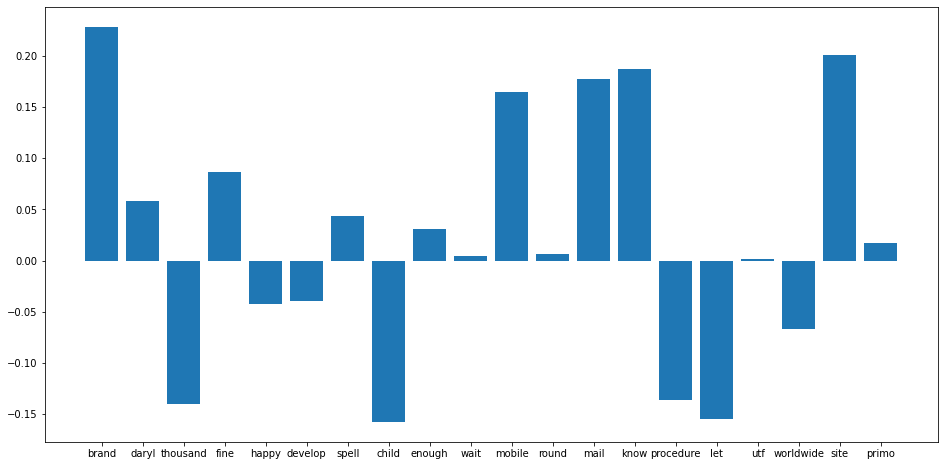

In [ ]:
plt.figure(figsize=(16,8))
plt.bar(words_spam,coef)
plt.show()

In [ ]:
coef = [0.22830830499455285, 0.05797650037363943, -0.1401788872682414, 0.08616501909038843, -0.04242079576438343, -0.03999191586560739, 0.04374066343701005, -0.15768884325995486, 0.03087958854350581, 0.004000949078240986, 0.16498912022193377, 0.006007151192972845, 0.17742490063464755, 0.18682561139252835, -0.13630955247008125, -0.15479240138712957, 0.0010358690782179133, -0.06727855205203873, 0.2008405571787448, 0.016721150940665792]
words = ['brand', 'daryl', 'thousand', 'fine', 'happy', 'develop', 'spell', 'child', 'enough', 'wait', 'mobile', 'round', 'mail', 'know', 'procedure', 'let', 'utf', 'worldwide', 'site', 'primo']

In [ ]:
import numpy as np

idx = np.argsort(-np.abs(coef))

coef = np.array(coef)
words = np.array(words)

coef = coef[idx]
words = words[idx]

idx = np.where(np.abs(coef)>0.01)

coef = coef[idx]
words = words[idx]

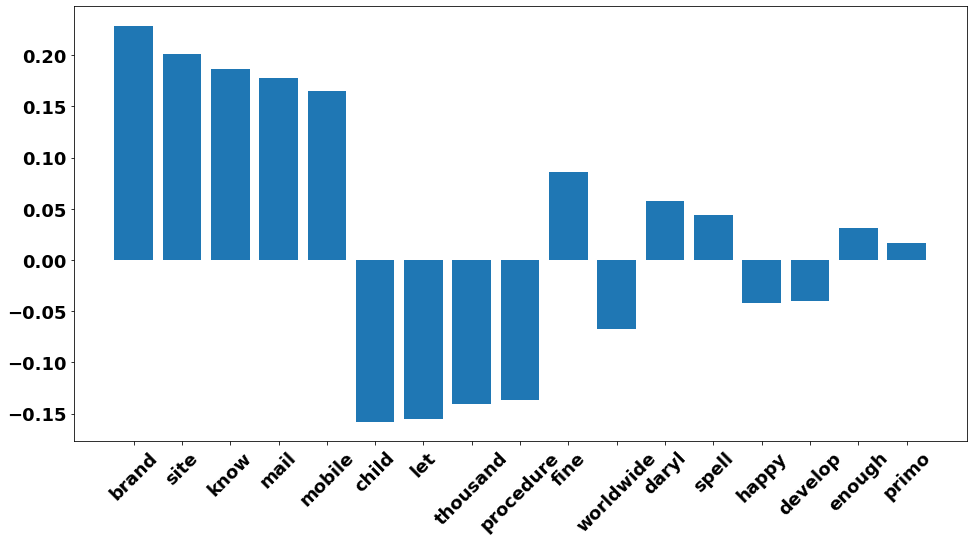

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

plt.figure(figsize=(16,8))

font = {'family' : 'normal',
         'weight' : 'bold',
         'size'   : 18}
matplotlib.rc('font', **font)

idx = np.array([0,1,2,3,5,6,7])
idx=range(len(words))
words_plot = words[idx]
coef_plot = coef[idx]

plt.bar(words_plot,coef_plot)
plt.xticks(rotation=45)
plt.show()